In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '/content/drive/My Drive/Final DataSet/image_data.csv'
df = pd.read_csv(csv_file_path)

# Check if each file exists and create a mask for rows with valid file paths
def file_exists(file_path):
    return tf.io.gfile.exists(file_path)

# Filter out rows where the file does not exist
df['FileExists'] = df['Images'].apply(file_exists)
df = df[df['FileExists']].drop(columns=['FileExists'])  # Keep only rows with existing files
print(f"Removed {len(df) - df.shape[0]} rows with missing files.")

# One-hot encode the 'Category' column into separate columns
one_hot_df = pd.get_dummies(df['Category'], prefix='Category')

# Concatenate the new one-hot encoded columns with the original DataFrame
df = pd.concat([df, one_hot_df], axis=1)

# Split data into features and target
X = df['Images'].values  # Assuming the column with image paths is 'Images'
y = one_hot_df.values    # Use the one-hot encoded columns as target

# Split the data into training and test sets (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=df['Category'], random_state=42)

# Set image size and batch size
img_size = (299, 299)
batch_size = 32

# Preprocessing function for images
def preprocess_image(file_path):
    img = tf.keras.preprocessing.image.load_img(file_path.numpy().decode('utf-8'), target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return img

# Wrap the function to allow use with `tf.py_function`
def preprocess_image_with_py_func(file_path):
    img = tf.py_function(preprocess_image, [file_path], tf.float32)
    img.set_shape(img_size + (3,))  # Specify the shape explicitly
    return img

# Prepare tf.data.Dataset for batch processing
def prepare_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(lambda x, y: (preprocess_image_with_py_func(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Prepare train and test datasets
train_dataset = prepare_dataset(X_train, y_train)
test_dataset = prepare_dataset(X_test, y_test)

# Define the model using InceptionV3 as the base model
def create_model(input_shape, num_classes):
    # Load the InceptionV3 model with pre-trained ImageNet weights
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Set to True if you want to fine-tune the InceptionV3 layers

    # Add custom layers on top of InceptionV3
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add global average pooling layer to reduce dimensions
    x = Dropout(0.3)(x)  # Add dropout for regularization
    output = Dense(num_classes, activation='softmax')(x)  # Add final dense layer for classification

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Create the model
input_shape = (299, 299, 3)
num_classes = y.shape[1]  # Number of one-hot encoded classes
model = create_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with validation data to track test accuracy
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Final Test Accuracy: {test_acc:.2f}")


Removed 0 rows with missing files.
Epoch 1/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 1334s 3s/step - accuracy: 0.6978 - loss: 0.9029 - val_accuracy: 0.8606 - val_loss: 0.4303
Epoch 2/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 162s 317ms/step - accuracy: 0.8538 - loss: 0.4374 - val_accuracy: 0.8699 - val_loss: 0.3890
Epoch 3/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 162s 317ms/step - accuracy: 0.8689 - loss: 0.3851 - val_accuracy: 0.8782 - val_loss: 0.3689
Epoch 4/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 160s 312ms/step - accuracy: 0.8766 - loss: 0.3631 - val_accuracy: 0.8772 - val_loss: 0.3680
Epoch 5/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 162s 318ms/step - accuracy: 0.8817 - loss: 0.3473 - val_accuracy: 0.8860 - val_loss: 0.3548
Epoch 6/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 157s 307ms/step - accuracy: 0.8841 - loss: 0.3395 - val_accuracy: 0.8863 - val_loss: 0.3530
Epoch 7/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 156s 304ms/step - accuracy: 0.8825 - loss: 0.3360 - val_accuracy: 0.8882 - val_loss: 0.3474
Epoch 8/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 161

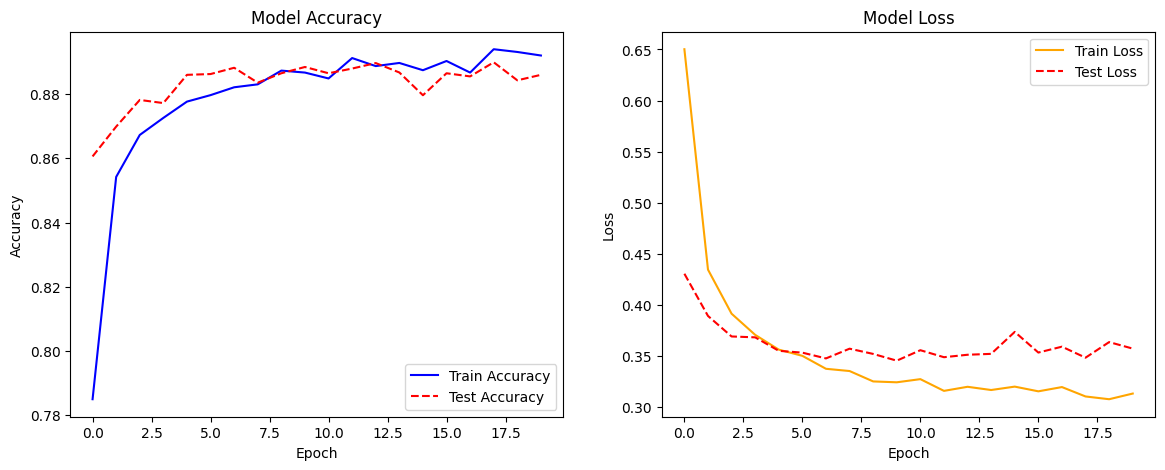

In [ ]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', color='red', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='orange')
plt.plot(history.history['val_loss'], label='Test Loss', color='red', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the training set
train_preds = model.predict(train_dataset)
train_preds_labels = np.argmax(train_preds, axis=1)  # Get the class labels
train_true_labels = np.argmax(y_train, axis=1)       # True class labels from one-hot encoding

# Generate classification report for training data
train_report = classification_report(train_true_labels, train_preds_labels, target_names=one_hot_df.columns)
print("Classification Report for Training Data:")
print(train_report)

# Predict on the test set
test_preds = model.predict(test_dataset)
test_preds_labels = np.argmax(test_preds, axis=1)    # Get the class labels
test_true_labels = np.argmax(y_test, axis=1)         # True class labels from one-hot encoding

# Generate classification report for test data
test_report = classification_report(test_true_labels, test_preds_labels, target_names=one_hot_df.columns)
print("Classification Report for Test Data:")
print(test_report)


511/511 ━━━━━━━━━━━━━━━━━━━━ 127s 235ms/step
Classification Report for Training Data:
                    precision    recall  f1-score   support

     Category_Wood       1.00      1.00      1.00      1966
Category_cardboard       0.92      0.96      0.94      2194
  Category_e-waste       0.99      0.96      0.97      1924
    Category_glass       0.94      0.90      0.92      2014
  Category_medical       0.95      0.97      0.96      2154
    Category_metal       0.89      0.93      0.91      1807
    Category_paper       0.93      0.90      0.91      2199
  Category_plastic       0.88      0.89      0.89      2094

          accuracy                           0.94     16352
         macro avg       0.94      0.94      0.94     16352
      weighted avg       0.94      0.94      0.94     16352

128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 325ms/step
Classification Report for Test Data:
                    precision    recall  f1-score   support

     Category_Wood       0.99      0.96      0.97

511/511 ━━━━━━━━━━━━━━━━━━━━ 120s 233ms/step
Training Data Classification Report:
                    precision    recall  f1-score   support

     Category_Wood       1.00      1.00      1.00      1966
Category_cardboard       0.92      0.96      0.94      2194
  Category_e-waste       0.99      0.96      0.97      1924
    Category_glass       0.94      0.90      0.92      2014
  Category_medical       0.95      0.97      0.96      2154
    Category_metal       0.89      0.93      0.91      1807
    Category_paper       0.93      0.90      0.91      2199
  Category_plastic       0.88      0.89      0.89      2094

          accuracy                           0.94     16352
         macro avg       0.94      0.94      0.94     16352
      weighted avg       0.94      0.94      0.94     16352

Training Data Accuracy: 0.94


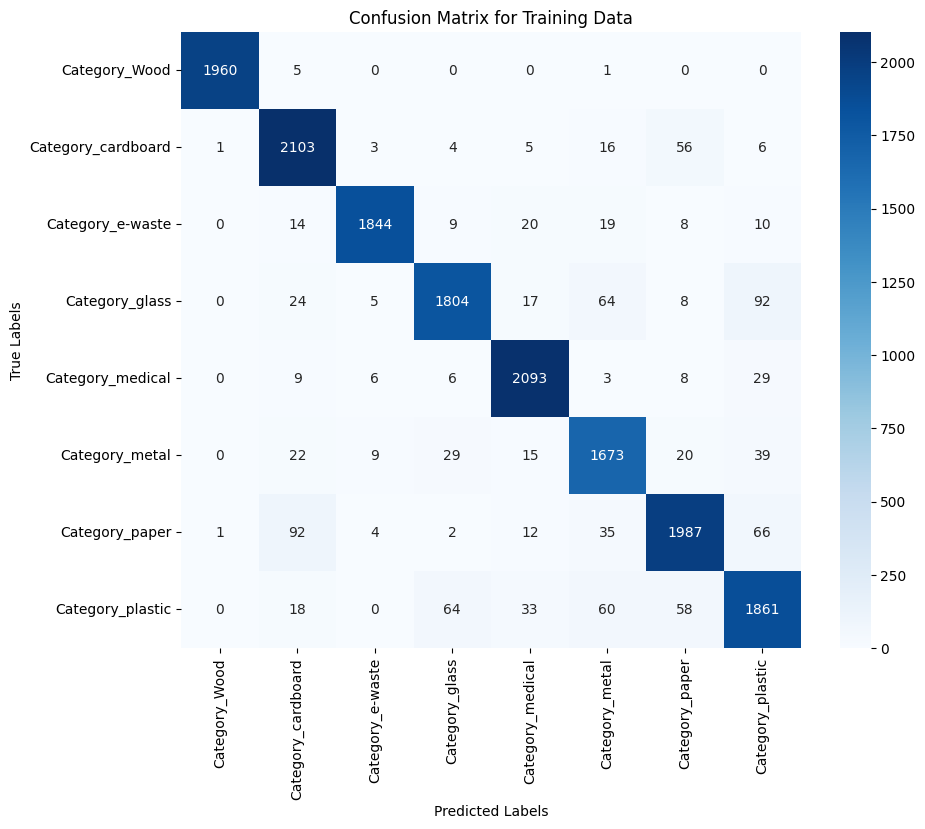

128/128 ━━━━━━━━━━━━━━━━━━━━ 37s 284ms/step
Test Data Classification Report:
                    precision    recall  f1-score   support

     Category_Wood       0.99      0.96      0.97       492
Category_cardboard       0.85      0.91      0.88       548
  Category_e-waste       0.94      0.90      0.92       481
    Category_glass       0.90      0.86      0.88       504
  Category_medical       0.91      0.92      0.91       539
    Category_metal       0.82      0.87      0.84       452
    Category_paper       0.86      0.85      0.86       550
  Category_plastic       0.82      0.82      0.82       523

          accuracy                           0.89      4089
         macro avg       0.89      0.89      0.89      4089
      weighted avg       0.89      0.89      0.89      4089

Test Data Accuracy: 0.89


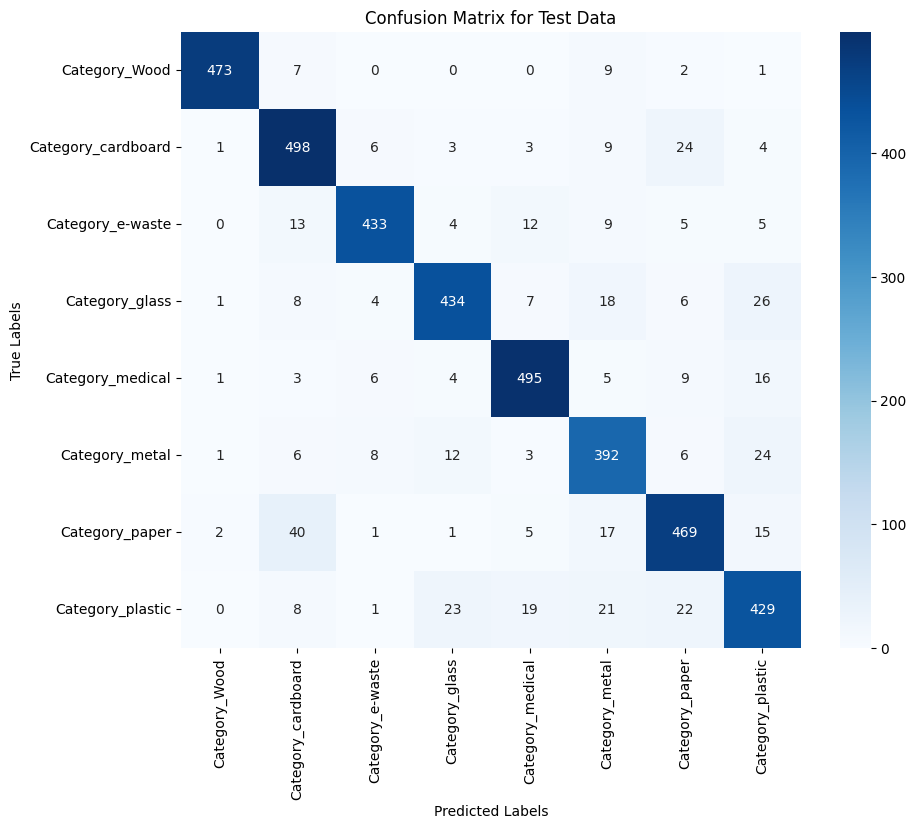

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the training set
train_preds = model.predict(train_dataset)
train_preds_labels = np.argmax(train_preds, axis=1)  # Convert predictions to class labels
train_true_labels = np.argmax(y_train, axis=1)       # Convert one-hot encoded labels to class labels

# Generate classification report, accuracy, and confusion matrix for training data
train_report = classification_report(train_true_labels, train_preds_labels, target_names=one_hot_df.columns)
train_accuracy = accuracy_score(train_true_labels, train_preds_labels)
train_conf_matrix = confusion_matrix(train_true_labels, train_preds_labels)

print("Training Data Classification Report:")
print(train_report)
print(f"Training Data Accuracy: {train_accuracy:.2f}")

# Plot confusion matrix for training data
plt.figure(figsize=(10, 8))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=one_hot_df.columns, yticklabels=one_hot_df.columns)
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Predict on the test set
test_preds = model.predict(test_dataset)
test_preds_labels = np.argmax(test_preds, axis=1)    # Convert predictions to class labels
test_true_labels = np.argmax(y_test, axis=1)         # Convert one-hot encoded labels to class labels

# Generate classification report, accuracy, and confusion matrix for test data
test_report = classification_report(test_true_labels, test_preds_labels, target_names=one_hot_df.columns)
test_accuracy = accuracy_score(test_true_labels, test_preds_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_preds_labels)

print("Test Data Classification Report:")
print(test_report)
print(f"Test Data Accuracy: {test_accuracy:.2f}")

# Plot confusion matrix for test data
plt.figure(figsize=(10, 8))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=one_hot_df.columns, yticklabels=one_hot_df.columns)
plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
